# Homework \#1

Alles Rebel

Computional Science PhD

## Julia Package Requirements

Run these cells before anything else just to ensure the julia environment has all the dependencies it needs!

In [1]:
import Pkg; 
Pkg.add("Distributions")
Pkg.add("PrettyTables")

using Base.MathConstants: golden
using Printf
using Random
using Distributions
using Statistics
using Dates
using PrettyTables
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


## Problem 1, 1D Unconstrained Optimization

This problem asks us to find a functioning unconstrained function optimizer. For gradability, we're asked to use the following template!

In [2]:
function optimizer1D(func, initial_point, initial_step_size)
    # optimization method used = XXX (fill in the XXX with the right name)
    # source(s) of code used = XXX (fill in the XXX with the right name)
    # ***code goes here***
    return final_point # also return any intermediate statistics required
end

optimizer1D (generic function with 1 method)

### Problem 1A

Since the professor recommended writing out our own version of the golden ratio search to get a feel for it, I'll do that here in Julia, using Algorithm 3.3 from the book! (Algorithms for Optimization, Kochenderfer and Wheeler). 

Note I just renamed some of the variables for better understanding, and instrumented the number of function calls done. Included some comments for future self (or other readers). Also added early convergence test, since we can check if we're with in tolerance already

In [3]:
# Algorithm 3.3 from the book! 
# (Algorithms for Optimization, Kochenderfer and Wheeler). 
# with book keeping additions, comments, along with early exit
# also modified the output to contain the actual difference between steps
# since we'll only use the left_eval as our estimate
function golden_section_search(f, left_input, right_input; n=1000, tol=1e-8 )
    # book keeping variables
    # A warning toggle for the user
    warn_long_convergence = 0
    # keep track of usage stats
    function_calls = 0
    # keep track of convergence
    output_convergence = 0
    
    #note, golden means golden ratio in Julia, Base.MathConstants.golden
    # we can check if we'll converge already, spit out a warning if we're
    # not giving golden ratio a change to do it's thing
    expected_n = (right_input - left_input) / ( tol * log(golden) )

    # Initial interior point, using the inverse of the golden ratio
    # labeled as rho, in the book
    inverse_golden = golden - 1
    interior_right_input = inverse_golden * right_input + (1 - inverse_golden) * left_input
    
    interior_right_eval = f(interior_right_input)
    function_calls += 1
    
    for i = 1 : n-1
        interior_left_input = inverse_golden * left_input + (1 - inverse_golden) * right_input
        
        interior_left_eval = f(interior_left_input)
        function_calls += 1
        
        # early exit, if we've hit tolerance threshold! *and n > 1
        # interior_left_eval is our next estimate for were the mid is
        # interior_right contains our last estimate
        if( i > 1 && abs(interior_right_eval - interior_left_eval) < tol )
            output_convergence = abs(interior_right_eval - interior_left_eval)
            break
        end
        
        if( interior_left_eval < interior_right_eval )
            # we can use the new interval, 
            # [ a, interior left, interior right]
            right_input = interior_right_input
            interior_right_input = interior_left_input 
            interior_right_eval = interior_left_eval
        else
            # note, we still have valid braket, but just flipping
            # since we want to keep our previously computed interior_right_eval
            # [b, interior_right_input, interior_left_input]
            left_input = right_input
            right_input = interior_left_input
        end
        
        if( i > expected_n && n < expected_n && warn_long_convergence == 0)
            warn_long_convergence = 1
            @printf("Doing best effort up to %d cycles; we probably won't converge")
            @printf("Try again with %d to converge with %f tolerance\n", expected_n, tol)
        end
    end

    return left_input < right_input ? (left_input, output_convergence, function_calls) : (right_input, output_convergence, function_calls)
end

golden_section_search (generic function with 1 method)

At a high level, to get the univariate interval we'll use the book's algorithm for braketing - which will take the initial point and the step size and determine the interval to use golden section search on. It's possible the initial step size is far too small to emcompass the minima, so this will account for bad guesses of initial brakets.

The output of this process will be passed in to the golden section search, to find the actual minima! Again we'll steal from the book, Algorithm 3.1 (Algorithms for Optimization, Kochenderfer and Wheeler).

Same deal as earlier, just renamed some stuff so it's easier to understand for myself. (also instrumention so I can keep track of the function calls!) Along with some comments to understand in the future.

In [4]:
# Algorithm 3.1 from the book! 
# (Algorithms for Optimization, Kochenderfer and Wheeler). 
# with book keeping additions, and comments
# the key idea here is that we're aiming for a +, -, + pattern, 
# when evaluating input values. Once found, we return the interval
function bracket_minimum(f, initial_input=0, step=1e-2; expansion_factor=2.0)
    # init instrumentation
    function_calls = 0
    
    direction = 1;
    
    if step < 1e-10
        step=1e-2 
    end
    
    left_input, left_eval = initial_input, f(initial_input)
    function_calls += 1
    
    right_input, right_eval = left_input + step, f(left_input + step)
    function_calls += 1
    
    # this determines which direction we'll step in initially
    # the assumption is we're always steping in the direction
    # our goal is to find a + - + pattern
    if right_eval > left_eval
        # we just found a - +, so let's go backwards by swapping
        left_input, right_input = right_input, left_input
        left_eval, right_eval = right_eval, left_eval
        # now we have a + - pattern, we'll push right until we get a +
    end

    while true
        direction = (right_input - left_input) >= 0 ? 1.0 : -1.0
        new_right_input = right_input + step * direction
        new_right_eval = f(new_right_input)
        function_calls += 1
        
        # did we get + - +?
        if new_right_eval > right_eval
            # we're done!
            return left_input < new_right_input ? (left_input, new_right_input, function_calls) : (new_right_input, left_input, function_calls)
        end
        
        # we're not done, we just got a 
        # + - - pattern, we need to push right IF
        # the new one is smaller than all points
        # we'll increase step! to do this, and update the params
        left_input, left_eval = right_input, right_eval
        right_input, right_eval = new_right_input, new_right_eval
        step *= expansion_factor
    end
end

bracket_minimum (generic function with 3 methods)

Putting it all together, the template, the bracketing and finally the golden section search on the final bracket - we get our very own optimizer! 

In [5]:
function optimizer1D(func, initial_point, initial_step_size=1e-3; tol=1e-8)
    # optimization method used = Minimum Bracketing with Golden Section Search
    # source(s) of code used = Algorithms 3.1 and 3.3 from Algorithms for Optimization, Kochenderfer and Wheeler

    # extract out the interval using minimum bracketing (alg 3.1)
    left, right, function_calls_bracketing = bracket_minimum(func, initial_point, initial_step_size)
    
    # using the found interval, zero in on the actual optimia (alg 3.3)
    final_point, search_convergence_delta, function_calls_search = golden_section_search(func, left, right; tol)
    
    return final_point, function_calls_bracketing, function_calls_search, search_convergence_delta
end

optimizer1D (generic function with 2 methods)

Not bad at all, it works! And we rolled it outselves!

In [6]:
# Define the function to minimize
f(x) = (x - 2)^2 + 1
optimizer1D(f, 0)

(1.9998336982211455, 14, 21, 3.112310409392194e-10)

### Problem 1b

Generate 100 random real-valued starting points, based on specifications in the homework. Then I'm assuming I'm supposed to run this through our optimizer in a later homework stage

In [7]:
function generate_initial_points(left_limit=-10.0, right_limit=10.0,n=100)
    # Generate 100 random real-valued starting points as specified
    initial_points = Float64[] # could just do [], for any - but that's slower

    for i in 1:n # defaults to 100 points
        # y is uniformly picked in [-10.0, 10.0] by default
        # note, rand is already uniform, just need to cap the limits
        y = rand(Uniform(left_limit, right_limit))
        # choose + or - with equal probability, we'll use bitrand (50/50)
        sign = bitrand() == 0 ? -1 : 1
        x = sign * exp(y)
        push!(initial_points, x)
    end

    return initial_points
end

generate_initial_points (generic function with 4 methods)

In [8]:
generate_initial_points()

100-element Vector{Float64}:
     0.0021929300998132393
 19889.716026917326
     6.469495906283233e-5
     0.021922525633721452
     3.500321810025905
     0.8022821826803106
     0.0005877681241653684
     0.043979487025607306
  6880.937999259812
     0.023241532451400065
 11341.515398571477
     2.198572357523331
     0.036183990988855594
     ⋮
     4.511964235646229
  4286.529390901153
     4.76499531387331e-5
     9.689650367407335
     0.027542645053890338
   193.74844177895986
     1.043421431051485
     0.015199215878029164
  1432.022236253426
     0.08627073909514993
     9.578515478358737
     0.9750540678148236

### Problem 1c

Indeed, we'll have to use our initial points on the functions outlined in the assignment!

In [9]:
# Function definitions for f, g, and h
a = 2
f(x) = (1/2) * (x - a)^2
g(x) = (1/4) * x^4 - a * x
h(x) = exp(x) + exp(-x) - a * x  # y in range [-2, 2]

h (generic function with 1 method)

Note: to get the analytical solutions I took the first dervative, and set it to zero, and solved for x! This ends up being the location we're aiming for!

In [10]:
# Derivative for f(x): f'(x) = (x - a)
f_min_x = a
f_min_value = f(f_min_x)
@printf("f(x) minimum at x = %f, f(x) = %f \n", f_min_x, f_min_value)

# Derivative for g(x): g'(x) = x^3 - a
g_min_x = a^(1/3)
g_min_value = g(g_min_x)
@printf("g(x) minimum at x = %f, g(x) = %f \n", g_min_x, g_min_value)

# Derivative for h(x): h'(x) = e^x - e^(-x) - a
h_min_x = asinh(a / 2)
h_min_value = h(h_min_x)
@printf("h(x) minimum at x = %f, h(x) = %f \n", h_min_x, h_min_value)

f(x) minimum at x = 2.000000, f(x) = 0.000000 
g(x) minimum at x = 1.259921, g(x) = -1.889882 
h(x) minimum at x = 0.881374, h(x) = 1.065680 


Do the actual number crunching! We'll collect our sample

In [11]:
# Lists to store results
results_f = []
results_g = []
results_h = []

# Generate initial points for each function we'll be testing
initial_points_f = generate_initial_points(-10.0, 10.0, 100)
initial_points_g = generate_initial_points(-10.0, 10.0, 100)
initial_points_h = generate_initial_points(-2.0, 2.0, 100)

# Run the optimizer for each function!
for (func, analytical_solution, points, results) in zip([f, g, h], [f_min_x, g_min_x, h_min_x] ,[initial_points_f, initial_points_g, initial_points_h], [results_f, results_g, results_h])
    for x in points
        start_time = time()
        x_opt, bracket_evals, search_evals, convergence_measure = optimizer1D(func, x)
        elapsed_time = time() - start_time
        absolute_error = abs(x_opt - analytical_solution)
        push!(results, (absolute_error,convergence_measure, bracket_evals + search_evals, elapsed_time))
    end
end

Process the results into the table required by the assignment!

In [12]:
function summarize_results(results)
    absolute_errors = [r[1] for r in results]
    convergences = [r[2] for r in results]
    evaluations = [r[3] for r in results]
    times = [r[4] for r in results]

    mean_absolute_error = mean(absolute_errors)
    std_absolute_error = std(absolute_errors)
    mean_convergence = mean(convergences)
    std_convergence = std(convergences)
    mean_evaluations = mean(evaluations)
    std_evaluations = std(evaluations)
    mean_time = mean(times) * 1e3 # conversion to millisecond
    std_time = std(times) * 1e3 # conversion to millisecond

    return (mean_absolute_error, std_absolute_error, mean_convergence, std_convergence, mean_evaluations, std_evaluations, mean_time, std_time)
end

# Summarize results for each function
summary_f = summarize_results(results_f)
summary_g = summarize_results(results_g)
summary_h = summarize_results(results_h)

# Print results in a 3x4 table
# Create a Table to display results as a table
using PrettyTables

headers = ["Function", "Absolute Error (mean ± std)", "Convergence (mean ± std)", "Evaluations (mean ± std)", "Time (ms) (mean ± std)"]
fdata = hcat("f(x)", @sprintf("%.4e ± %.4e", summary_f[1], summary_f[2]), @sprintf("%.4e ± %.4e", summary_f[3], summary_f[4]), @sprintf("%.2f ± %.2f", summary_f[5], summary_f[6]), @sprintf("%.2f ± %.2f", summary_f[7], summary_f[8]))
gdata = hcat("g(x)", @sprintf("%.4e ± %.4e", summary_g[1], summary_g[2]), @sprintf("%.4e ± %.4e", summary_g[3], summary_g[4]), @sprintf("%.2f ± %.2f", summary_g[5], summary_g[6]), @sprintf("%.2f ± %.2f", summary_g[7], summary_g[8]))
hdata = hcat("h(x)", @sprintf("%.4e ± %.4e", summary_h[1], summary_h[2]), @sprintf("%.4e ± %.4e", summary_h[3], summary_h[4]), @sprintf("%.2f ± %.2f", summary_h[5], summary_h[6]), @sprintf("%.2f ± %.2f", summary_h[7], summary_h[8]))

pretty_table(vcat(fdata, gdata, hdata), header=headers)

┌──────────┬─────────────────────────────┬──────────────────────────┬──────────────────────────┬────────────────────────┐
│ Function │ Absolute Error (mean ± std) │ Convergence (mean ± std) │ Evaluations (mean ± std) │ Time (ms) (mean ± std) │
├──────────┼─────────────────────────────┼──────────────────────────┼──────────────────────────┼────────────────────────┤
│     f(x) │     3.8382e-04 ± 3.5115e-04 │  3.5472e-09 ± 2.8383e-09 │            41.47 ± 11.65 │            0.81 ± 8.02 │
│     g(x) │     1.8919e-04 ± 1.8901e-04 │  3.8894e-09 ± 2.9526e-09 │            39.37 ± 11.08 │            0.39 ± 3.80 │
│     h(x) │     2.3568e-04 ± 2.4861e-04 │  4.2791e-09 ± 2.5867e-09 │             30.37 ± 4.93 │            0.40 ± 3.99 │
└──────────┴─────────────────────────────┴──────────────────────────┴──────────────────────────┴────────────────────────┘


## Problem 2
I'm a grad! So we're writing Coordinate Descent!

The coordinate descent algorithm fixes all axes and optimizes a function along a specific dimension. And once we have that optimization, we use that value to optimize the next dimention. 

For example, \( f(x, y) \), we define the following functions that use x on it's own and y on it's own:

- g(x) = f(x, y)
- h(y) = f(x, y)

Starting with an initial value for \( y \), say \( y_i \), we first optimize \( g(x) = f(x, y_i) \). This gives us the new value \( x_new \), where \( g(x) \) reaches its minimum. We then take \( x_new \), and plug it into \( h(y) = f(x_new, y) \) and optimize until we get a y_new. We ping pong back and forth, keeping the best value for all dimensions! (This can be extened to more than just 2.

## Problem 2A

We'll implement the algorithm using our existing solver! (the one we ran up above, optimizer1D, based on algo 3.1 and 3.3 from the book).

In [13]:
function coordinate_descent_2d(f, x, y; tol=1e-3)
    function_calls = 0
    
    while true        
        g(x) = f(x,y)
        function_calls += 1
        
        # hold y, and optimize x!
        x_new, bracket_evals, search_evals = optimizer1D(g, x)
        function_calls += (search_evals + bracket_evals)
        
        # optimize y, with the new x
        h(y) = f(x_new, y)
        y_new, bracket_evals, search_evals = optimizer1D(h, y)
        function_calls += (search_evals + bracket_evals)
        
        # check if the new values are within tolerance to quit
        convergence_check = ((x_new - x)^2 + (y_new - y)^2)^(1/2)
        
        if convergence_check < tol
            # yeah! we're done
            return x_new, y_new, convergence_check, function_calls
        end
        
        # update to new points
        x, y = x_new, y_new
    end
end

coordinate_descent_2d (generic function with 1 method)

## Problem 2B

Let's let the 2D coordinate descent loose on some example functions and report the results!

I picked Rosenbrock's *Banana* Function: $f(x_1, x_2) = (a-x_1)^2 + b(x_2-x_1^2)^2$
where the minimum is $f(1,1) = 0$ with parameters $a=1$ and $b=5$. (as recommended by the homework)

As the second one is Booth's Function:
$f(x_1, x_2) = (x_1+2x_2-7)^2 + (2x_1+x_2-5)^2$ where $f(1,3) = 0$ is the the minimum

In [14]:
booth(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2

a = 1
b = 5
banana(x, y) = (a - x)^2 + b*(y - x^2)^2

banana (generic function with 1 method)

In [15]:
# Lists to store results
results_booth = []
results_banana = []

# Generate initial points for each function we'll be testing
initial_points_booth = (generate_initial_points(-10.0, 10.0, 100), generate_initial_points(-10.0, 10.0, 100))
initial_points_banana = (generate_initial_points(-10.0, 10.0, 100), generate_initial_points(-10.0, 10.0, 100))

# Run the optimizer for each function!
for (func, analytical_solution, points, results) in 
    zip([booth, banana], [booth(1,1), banana(1,3)] ,[initial_points_booth, initial_points_banana], [results_booth, results_banana])
    initial_x_points, initial_y_points = points
    for x in initial_x_points
        for y in initial_y_points
            start_time = time()
            x_opt, y_opt, convergence_measure, function_calls = coordinate_descent_2d(func, x, y)
            elapsed_time = time() - start_time
            absolute_error = abs(func(x_opt,y_opt) - analytical_solution)
            push!(results, (absolute_error, convergence_measure, function_calls, elapsed_time))
        end
    end
end

Same deal as before, we'll go ahead and create a pretty table as the assignment requests!

In [16]:
# Summarize results for each function
summary_booth = summarize_results(results_booth)
summary_banana = summarize_results(results_banana)

# Print results in a 2x4 table
# Create a Table to display results as a table
using PrettyTables

headers = ["Function", "Absolute Error (mean ± std)", "Convergence (mean ± std)", "Evaluations (mean ± std)", "Time (ms) (mean ± std)"]
boothdata = hcat("Booth", @sprintf("%.4e ± %.4e", summary_booth[1], summary_booth[2]), @sprintf("%.4e ± %.4e", summary_booth[3], summary_booth[4]), @sprintf("%.2f ± %.2f", summary_booth[5], summary_booth[6]), @sprintf("%.2f ± %.2f", summary_booth[7], summary_booth[8]))
bananadata = hcat("Banana", @sprintf("%.4e ± %.4e", summary_banana[1], summary_banana[2]), @sprintf("%.4e ± %.4e", summary_banana[3], summary_banana[4]), @sprintf("%.2f ± %.2f", summary_banana[5], summary_banana[6]), @sprintf("%.2f ± %.2f", summary_banana[7], summary_banana[8]))

pretty_table(vcat(boothdata, bananadata), header=headers)

┌──────────┬─────────────────────────────┬──────────────────────────┬──────────────────────────┬────────────────────────┐
│ Function │ Absolute Error (mean ± std) │ Convergence (mean ± std) │ Evaluations (mean ± std) │ Time (ms) (mean ± std) │
├──────────┼─────────────────────────────┼──────────────────────────┼──────────────────────────┼────────────────────────┤
│    Booth │     2.0000e+01 ± 1.2486e-06 │  7.5775e-04 ± 1.7009e-04 │         1377.65 ± 657.16 │           1.51 ± 14.26 │
│   Banana │     2.0000e+01 ± 7.4769e-05 │  9.3644e-04 ± 1.0341e-04 │    215693.74 ± 356795.45 │          41.86 ± 68.60 │
└──────────┴─────────────────────────────┴──────────────────────────┴──────────────────────────┴────────────────────────┘


## Extra Credit Time!!

While doing the assignment it's pretty clear that convergence tolerance has a HUGE effect on overall accuracy and runtime of the optimization. I'll show that this fixed value (usually pretty small in the above runs) has a sizable impact on not just the stopping criterion, but the number of function evaluations themselves for both problems.

### Problem 1, plotting function evals against tolerance!
We'll rerun the entire pipeline, but this time adjusting the tolerance in steps, graphing them to see how it impacts the number of evals (and overall runtime indirectly). Added error bars, but they are a bit hard to read, so also plotted in a table them (below the graph)!
Note the errors are the statistics from the sampled population, not from our knowledge of the mean. (mean is the plotted point)

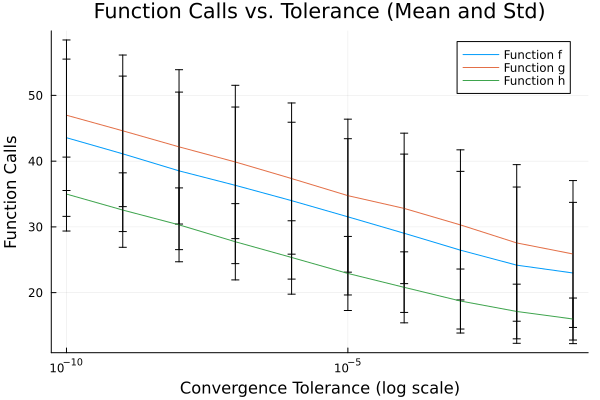

In [17]:
# Lists to store results for different tolerance levels
tolerance_values = 1 ./ 10 .^ (1:10)  # Sweep tolerance from 1e-1 to 1e-10
function_calls_f = []
function_calls_g = []
function_calls_h = []

# Generate initial points for each function we'll be testing
initial_points_f = generate_initial_points(-10.0, 10.0, 100)
initial_points_g = generate_initial_points(-10.0, 10.0, 100)
initial_points_h = generate_initial_points(-2.0, 2.0, 100)

# Define functions f, g, h and their analytical solutions f_min_x, g_min_x, h_min_x

# Sweep over tolerance values
for tol in tolerance_values
    total_calls_f = []
    total_calls_g = []
    total_calls_h = []
    
    # Run the optimizer for each function with the given tolerance
    for (func, analytical_solution, points, total_calls) in 
        zip([f, g, h], [f_min_x, g_min_x, h_min_x], [initial_points_f, initial_points_g, initial_points_h], [total_calls_f, total_calls_g, total_calls_h])
        for x in points
            # Call optimizer1D with the current tolerance
            x_opt, bracket_evals, search_evals, convergence_measure = optimizer1D(func, x; tol=tol)
            
            # Collect total function evaluations
            append!(total_calls, bracket_evals + search_evals)
        end
    end
    
    # Append the total function calls for each function at this tolerance
    push!(function_calls_f, total_calls_f)
    push!(function_calls_g, total_calls_g)
    push!(function_calls_h, total_calls_h)
end

# Calculate means and standard deviations for function calls
means_f = [mean(calls) for calls in function_calls_f]
stds_f = [std(calls) for calls in function_calls_f]

means_g = [mean(calls) for calls in function_calls_g]
stds_g = [std(calls) for calls in function_calls_g]

means_h = [mean(calls) for calls in function_calls_h]
stds_h = [std(calls) for calls in function_calls_h]

# Plotting the results with error bars
plot(tolerance_values, means_f, yerror=stds_f, label="Function f", xlabel="Convergence Tolerance (log scale)", ylabel="Function Calls", xscale=:log10)
plot!(tolerance_values, means_g, yerror=stds_g, label="Function g")
plot!(tolerance_values, means_h, yerror=stds_h, label="Function h", title="Function Calls vs. Tolerance (Mean and Std)")

In [18]:
headers = ["Function", "Tolerance", "Function Calls (mean ± std)"]

data_f = hcat(["Function f" for _ in 1:length(tolerance_values)], string.(tolerance_values), [@sprintf("%.2f ± %.2f", means_f[i], stds_f[i]) for i in 1:length(means_f)])
data_g = hcat(["Function g" for _ in 1:length(tolerance_values)], string.(tolerance_values), [@sprintf("%.2f ± %.2f", means_g[i], stds_g[i]) for i in 1:length(means_g)])
data_h = hcat(["Function h" for _ in 1:length(tolerance_values)], string.(tolerance_values), [@sprintf("%.2f ± %.2f", means_h[i], stds_h[i]) for i in 1:length(means_h)])

table_data = vcat(data_f, data_g, data_h)
pretty_table(table_data, header=headers)

┌────────────┬───────────┬─────────────────────────────┐
│   Function │ Tolerance │ Function Calls (mean ± std) │
├────────────┼───────────┼─────────────────────────────┤
│ Function f │       0.1 │               22.99 ± 10.74 │
│ Function f │      0.01 │               24.18 ± 11.88 │
│ Function f │     0.001 │               26.46 ± 11.99 │
│ Function f │    0.0001 │               29.03 ± 12.04 │
│ Function f │    1.0e-5 │               31.53 ± 11.88 │
│ Function f │    1.0e-6 │               33.99 ± 11.92 │
│ Function f │    1.0e-7 │               36.32 ± 11.90 │
│ Function f │    1.0e-8 │               38.52 ± 11.98 │
│ Function f │    1.0e-9 │               41.11 ± 11.82 │
│ Function f │   1.0e-10 │               43.56 ± 11.95 │
│ Function g │       0.1 │               25.88 ± 11.16 │
│ Function g │      0.01 │               27.56 ± 11.91 │
│ Function g │     0.001 │               30.30 ± 11.41 │
│ Function g │    0.0001 │               32.81 ± 11.44 │
│ Function g │    1.0e-5 │     

## Problem 2

Doing the same plot on problem 2 is insane!!! I had to reduce the number of points to get something that converges within a reasonable time frame. In other words, I had to significantly reduce the sample size due to the tight tolerances - just to get data in a reasonable period of time. To keep it consistent, I used the same number of points across all runs.

But based off problem 1 and looking at this one, it appears having the samples follow a power law relationship with how tight the tolerance may be an interesting thing to investigate. Another observation is that the errors aren't the same across the entire tolerance range (like it was in Problem 1!!). This may be due to a sampling issue, since I had to reduce the number of samples to make this run within minutes instead of longer.

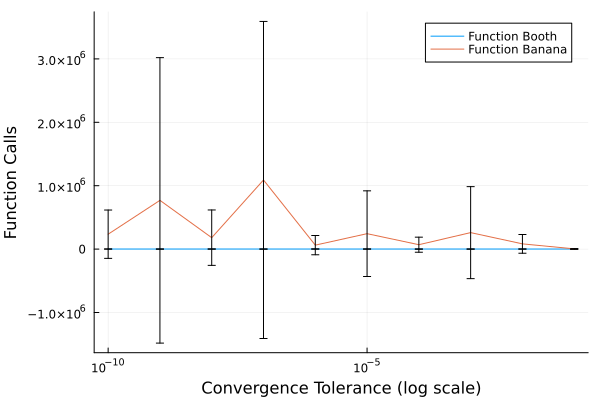

In [19]:
# Lists to store results for different tolerance levels
tolerance_values = 1 ./ 10 .^ (1:10)  # Sweep tolerance from 1e-1 to 1e-10
function_calls_booth = []
function_calls_banana = []

# Sweep over tolerance values
for tol in tolerance_values

    # Lists to store results per tolerance
    results_booth = []
    results_banana = []

    # Generate initial points for each function we'll be testing
    initial_points_booth = (generate_initial_points(-10.0, 10.0, 10), generate_initial_points(-10.0, 10.0, 10))
    initial_points_banana = (generate_initial_points(-10.0, 10.0, 10), generate_initial_points(-10.0, 10.0, 10))

    # Run the optimizer for each function!
    for (func, analytical_solution, points, results) in 
        zip([booth, banana], [booth(1,1), banana(1,3)] ,[initial_points_booth, initial_points_banana], [results_booth, results_banana])
        initial_x_points, initial_y_points = points
        for x in initial_x_points
            for y in initial_y_points
                start_time = time()
                x_opt, y_opt, convergence_measure, function_calls = coordinate_descent_2d(func, x, y)
                elapsed_time = time() - start_time
                absolute_error = abs(func(x_opt,y_opt) - analytical_solution)
                push!(results, function_calls)
            end
        end
    end
    
    # Append the total function calls for each function at this tolerance
    push!(function_calls_booth, results_booth)
    push!(function_calls_banana, results_banana)
end

# Calculate means and standard deviations for function calls
means_booth = [mean(calls) for calls in function_calls_booth]
stds_booth = [std(calls) for calls in function_calls_booth]

means_banana = [mean(calls) for calls in function_calls_banana]
stds_banana = [std(calls) for calls in function_calls_banana]

# Plotting the results with error bars
plot(tolerance_values, means_booth, yerror=stds_booth, label="Function Booth", xlabel="Convergence Tolerance (log scale)", ylabel="Function Calls", xscale=:log10)
plot!(tolerance_values, means_banana, yerror=stds_banana, label="Function Banana")


In [20]:
headers = ["Function", "Tolerance", "Function Calls (mean ± std)"]

data_booth = hcat(["Booth" for _ in 1:length(tolerance_values)], string.(tolerance_values), [@sprintf("%.2f ± %.2f", means_booth[i], stds_booth[i]) for i in 1:length(means_booth)])
data_banana = hcat(["Banana" for _ in 1:length(tolerance_values)], string.(tolerance_values), [@sprintf("%.2f ± %.2f", means_banana[i], stds_banana[i]) for i in 1:length(means_banana)])

table_data = vcat(data_booth, data_banana)
pretty_table(table_data, header=headers)

┌──────────┬───────────┬─────────────────────────────┐
│ Function │ Tolerance │ Function Calls (mean ± std) │
├──────────┼───────────┼─────────────────────────────┤
│    Booth │       0.1 │            1114.30 ± 662.42 │
│    Booth │      0.01 │            1117.66 ± 427.85 │
│    Booth │     0.001 │             940.38 ± 451.58 │
│    Booth │    0.0001 │            1127.36 ± 579.99 │
│    Booth │    1.0e-5 │            1206.75 ± 680.65 │
│    Booth │    1.0e-6 │            1303.13 ± 640.67 │
│    Booth │    1.0e-7 │            1033.73 ± 569.34 │
│    Booth │    1.0e-8 │            1144.17 ± 448.77 │
│    Booth │    1.0e-9 │             931.21 ± 375.16 │
│    Booth │   1.0e-10 │            1249.09 ± 710.16 │
│   Banana │       0.1 │           3528.63 ± 4324.00 │
│   Banana │      0.01 │        82701.04 ± 147683.66 │
│   Banana │     0.001 │       260206.47 ± 725672.58 │
│   Banana │    0.0001 │        69438.88 ± 118498.50 │
│   Banana │    1.0e-5 │       243435.49 ± 675326.00 │
│   Banana